Epoch 1/10
29/29 [==============================] - 98s 3s/step - loss: 2.2916 - accuracy: 0.1478 - val_loss: 2.2172 - val_accuracy: 0.2400
Epoch 2/10
29/29 [==============================] - 70s 2s/step - loss: 2.1846 - accuracy: 0.2589 - val_loss: 2.1660 - val_accuracy: 0.3100
Epoch 3/10
29/29 [==============================] - 70s 2s/step - loss: 2.0978 - accuracy: 0.3356 - val_loss: 2.1437 - val_accuracy: 0.3500
Epoch 4/10
29/29 [==============================] - 69s 2s/step - loss: 2.0426 - accuracy: 0.4033 - val_loss: 2.1085 - val_accuracy: 0.3800
Epoch 5/10
29/29 [==============================] - 70s 2s/step - loss: 1.9692 - accuracy: 0.4511 - val_loss: 2.0824 - val_accuracy: 0.3900
Epoch 6/10
29/29 [==============================] - 69s 2s/step - loss: 1.9134 - accuracy: 0.4644 - val_loss: 2.0852 - val_accuracy: 0.3600
Epoch 7/10
29/29 [==============================] - 71s 2s/step - loss: 1.8704 - accuracy: 0.4767 - val_loss: 2.0585 - val_accuracy: 0.3700
Epoch 8/10
29/29 [==

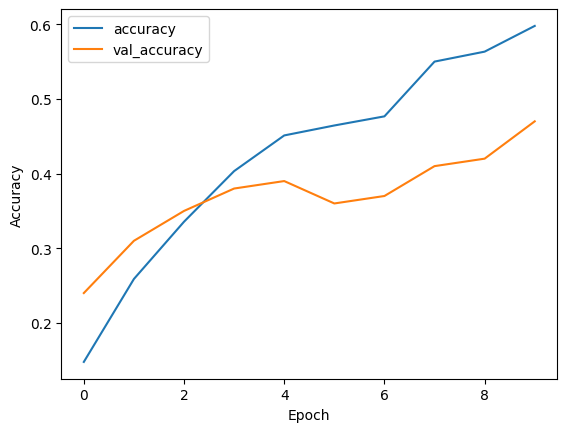

4/4 [==============================] - 2s 456ms/step - loss: 1.9939 - accuracy: 0.4700
Test accuracy: 47.00%
Model saved


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
import pickle
import os

# Load the preprocessed pickle file
with open('dataset/preprocessed_data.pickle', 'rb') as f:
    data = pickle.load(f)

X_train, y_train = data['train_dataset'], data['train_labels']
X_test, y_test = data['test_dataset'], data['test_labels']

# Define a function to create the RNN model
def create_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Reshape(target_shape=(87, 1400), input_shape=input_shape),
        layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
        layers.Bidirectional(layers.LSTM(64)),
        layers.Dense(512, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Define a function to create the CNN model
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(256, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Create the RNN model
input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))
model = create_model(input_shape, num_classes)

# Create the CNN model
input_shape_cnn = (87, 1400, 1)
cnn_model = create_cnn_model(input_shape_cnn, num_classes)

# Merge the RNN and CNN models
merged = layers.concatenate([model.output, cnn_model.output])
output = layers.Dense(num_classes, activation='softmax')(merged)
model = models.Model(inputs=[model.input, cnn_model.input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit([X_train, X_train], y_train, epochs=10, validation_data=([X_test, X_test], y_test))

# Plot the accuracy and loss curves during training
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate the model on the test set
loss, accuracy = model.evaluate([X_test, X_test], y_test)
print(f'Test accuracy: {accuracy*100:.02f}%')

if os.path.exists('models/trained_RNN_CNN.h5'):
    print('File already exists')
else:
    model.save('models/trained_RNN_CNN.h5')
    print('Model saved')
